# Calculate and plot model disagreement #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import numpy as np
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import load_data, ext_freq, utils
from cdrmip_extremes.plotting import plot_extremes

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load extreme frequency data ##

In [3]:
ext_freq_data = load_data.load_ext_freq_data()

In [4]:
heat_freq = {
    model: ds_dict['heat_exceedances'] for model, ds_dict in ext_freq_data.items()
}
cold_freq = {
    model: ds_dict['cold_exceedances'] for model, ds_dict in ext_freq_data.items()
}

### Calculate differences between GWLs and model agreement ###

In [5]:
heat_differences, heat_agreement = ext_freq.calc_gwl_differences(heat_freq)
cold_differences, cold_agreement = ext_freq.calc_gwl_differences(cold_freq)

### Calculate standard deviation ###

In [6]:
heat_freq_all = xr.concat(list(heat_differences.values()),
                              dim='model',
                              compat='override',
                              coords='minimal'
                             )

cold_freq_all = xr.concat(list(cold_differences.values()),
                              dim='model',
                              compat='override'
                              ,coords='minimal'
                             )
# Calculate std_dev
heat_freq_std_dev = heat_freq_all.std(dim='model')
cold_freq_std_dev = cold_freq_all.std(dim='model')

## Plot ##

In [7]:
def add_colorbar(axes,norm,cmap,label,extend=False,custom_ticks=False,custom_labels=False):
    # Colorbar for `norm2` across the last column
    cbar_ax = fig.add_axes(axes)  # [left, bottom, width, height]
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        cax=cbar_ax, 
        orientation='vertical',
        label=label,
        extend=extend,
        pad=0.02
    )
    if custom_ticks:
        cbar.set_ticks(custom_ticks)
        cbar.ax.set_yticklabels(custom_labels)
        cbar.ax.tick_params(labelsize=10)  # Adjust tick label size
    cbar.set_label(label,fontsize=12)
    return cbar_ax, cbar

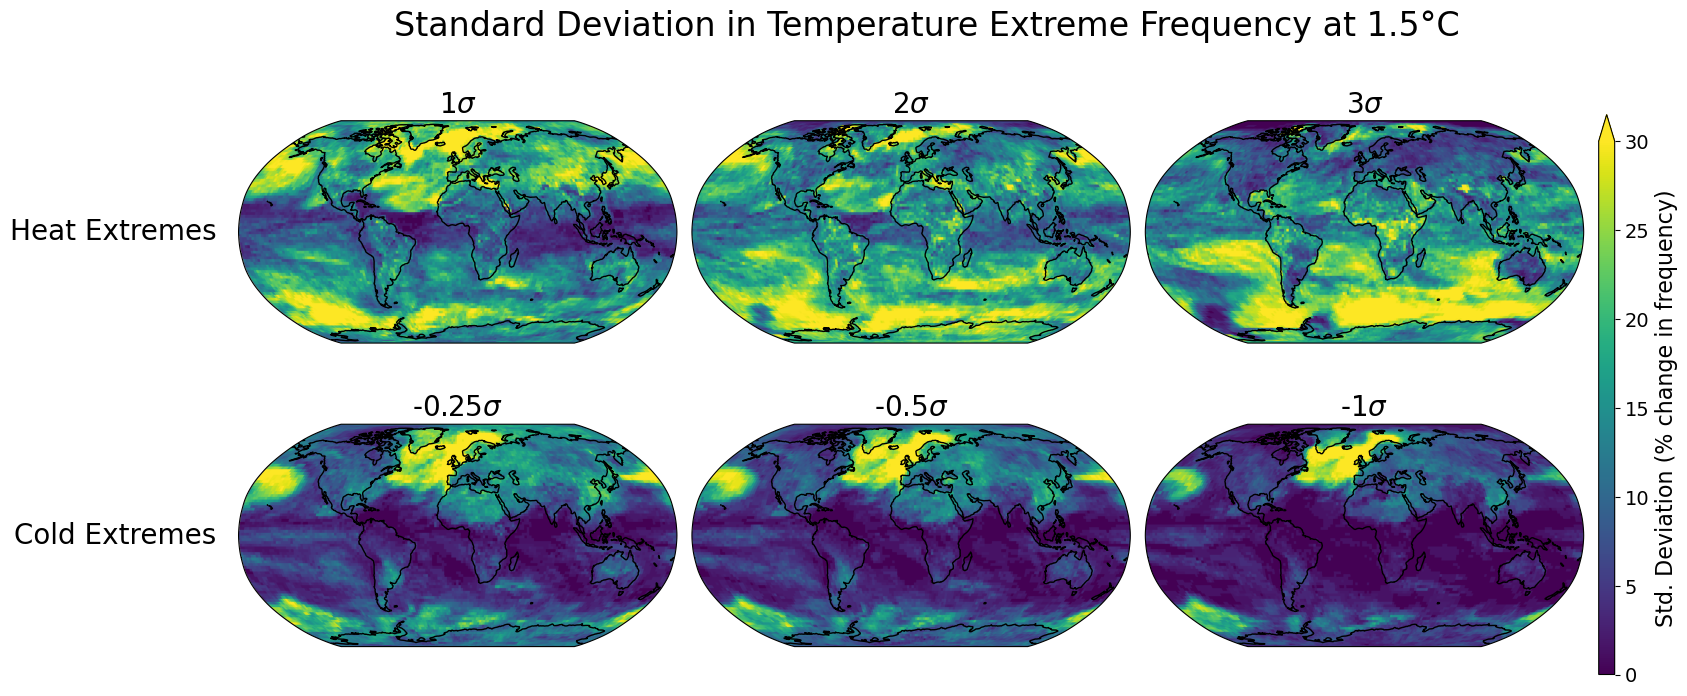

In [8]:
to_plot = {}
thresholds = ['sigma1','sigma2','sigma3']
threshold_symbs1 = ['1$\sigma$','2$\sigma$','3$\sigma$']
threshold_symbs2 = ['-0.25$\sigma$','-0.5$\sigma$','-1$\sigma$']
gwl=1.5
exceedance_heat = heat_freq_std_dev
exceedance_cold = cold_freq_std_dev
data = [('heat',exceedance_heat),('cold',exceedance_cold)]
for ext_type, exceedance in data:
    differences = {}
    for threshold in thresholds:
        std_dev = exceedance[threshold].sel(gwl=gwl)
        differences[threshold] = std_dev
    to_plot[ext_type] = differences

fig, axes = plt.subplots(2,
                         3,
                         subplot_kw={"projection":ccrs.Robinson()},
                         figsize=(16,7),
                         sharey=True,
                        )
cbar_kwargs_diff = {"fraction": 0.06, "aspect": 20,
                "label":"Change in %",'orientation':'horizontal',
                'location':'bottom','pad':0.05,
               } 


for row_index, ext_type in enumerate(to_plot.keys()):
    if ext_type == 'heat':
        threshold_symbs=threshold_symbs1
    else:

        threshold_symbs=threshold_symbs2
    for col_index, threshold in enumerate(to_plot[ext_type].keys()):
        ax = axes[row_index,col_index]
        im = ax.imshow(to_plot[ext_type][threshold],
                       transform=ccrs.PlateCarree(),
                       cmap='viridis',
                       origin='lower',
                       extent=(0,360,-90,90),
                       vmin=0,
                       vmax=30
                      )
        ax.coastlines()
        ax.set_title(f"{threshold_symbs[col_index]}",fontsize=20)


norm1 = Normalize(vmin=0, vmax=30)  # For heat extremes
norm2 = Normalize(vmin=0, vmax=30)  # For cold extremes

cbar_ax2, cbar2 = add_colorbar([1.0,0.05,0.01,0.8],
                               norm2,
                               'viridis',
                              "Std. Deviation (% change in frequency)",
                               extend = 'max',
                               # custom_ticks = [-30, -20, -10, 0, 10, 20, 30],
                               # custom_labels = ['-30%', '-20%', '-10%', '0', '10%', '20%', '30%'],
                              )
cbar2.set_label("Std. Deviation (% change in frequency)", fontsize=16)
cbar2.ax.tick_params(labelsize=14)


axes[0][0].annotate('Heat Extremes',
                    xy = (-0.05,0.5),
                    xycoords="axes fraction",
                    ha='right',
                    va='center',
                    fontsize=20,
                    rotation=0
                   )
axes[1][0].annotate('Cold Extremes',
                    xy = (-0.05,0.5),
                    xycoords="axes fraction",
                    ha='right',
                    va='center',
                    fontsize=20,
                    rotation=0
                   )
fig.suptitle(f'Standard Deviation in Temperature Extreme Frequency at {gwl}°C',x=0.58,y=1.0,fontsize=24)
fig.tight_layout()
plt.show()